# HW03 Fine-tuning

I recommend to work in [Lightning studio](https://lightning.ai/simecek/studios/fastai-transfer-learning-fine-tuning~01hv3p406bs3pebc3xm2qwtwz1) (and not Colab), because of preinstalled environment and permanent disk space.

## Data preparation

 1. You need to upload your dataset to the virtual machine. Since the dataset is relatively small, it's easiest to ZIP the data and use the 'Upload Files' button in the top left corner.
 2. You can unzip the data either through the Terminal or directly within the Jupyter Notebook using the command: `!unzip YOURFILENAME.zip`
 3. Optionally, organize the image files as shown in the schema below.

```
DATASET_NAME/
│
├── train/
│   ├── CATEGORY1/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── CATEGORY2/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── ...
│
└── test/
    ├── CATEGORY1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    ├── CATEGORY2/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── ...
```

If the data are organized in this form, you can obtain dataloaders as below. Otherwise, adapt `ImageDataLoaders` / `DataBlocks` accordingly.


In [1]:
!unzip dataset.zip

Archive:  dataset.zip
replace train/chase/image22.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

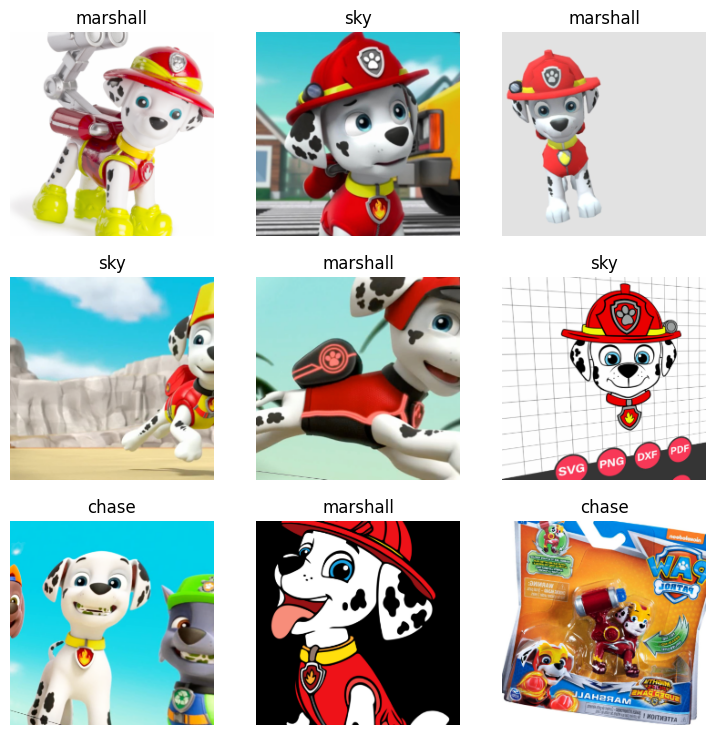

In [ ]:
from fastai.vision.all import *
from pathlib import Path

# Path to the unzipped dataset folder
path = Path('/teamspace/studios/this_studio/train')

dls = ImageDataLoaders.from_folder(
    path,                 # Path to the train folder
    train='.',            # Use the entire train folder for splitting
    valid_pct=0.2,        # 20% of the data will be used for validation
    seed=42,              # Set a seed for reproducibility
    item_tfms=Resize(460),# Resize the images to 460x460 (or your desired size)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation 
    bs=64                 # Batch size 64
)

dls.show_batch(max_n=9)

In [ ]:
import warnings

# to ignore the palette warnings
warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images",
    category=UserWarning
)

## Train the model

  1. Choose a pretrained model.
  2. Determine the optimal learning rate using the learning rate finder.
  3. Fine-tune the pretrained model to adapt it to your dataset.

Regarding the model, use rather [something smaller](https://www.kaggle.com/code/jhoward/which-image-models-are-best) from `timm` package. Architectures like convexnet, resnet, vgg or mobilenet should be fine.

In [ ]:
# TODO - you can change resnet18 to other architecture
# from timm import list_models
# list_models(pretrained=True)
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/zeus/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


SuggestedLRs(valley=0.0003311311302240938)

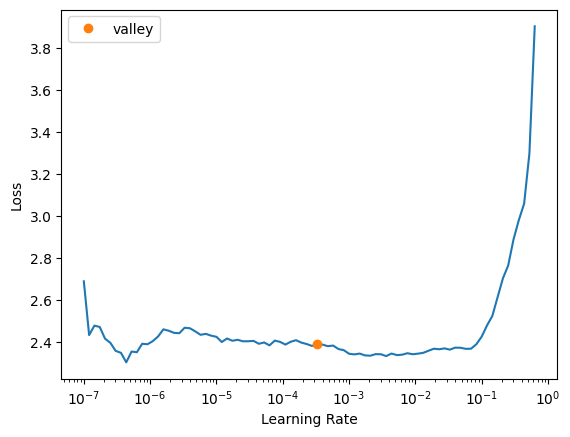

In [ ]:
learn.lr_find()

In [ ]:
lr =  0.0005
epochs =  10

In [ ]:
# TODO - you can change resnet18 to other architecture (same as above)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.497819,2.023150,0.776978,00:57


epoch,train_loss,valid_loss,error_rate,time
0,2.378805,2.027634,0.877698,01:06
1,2.255752,2.111296,0.892086,01:03
2,2.259492,2.276380,0.892086,01:08
3,2.286581,2.347775,0.892086,01:05
4,2.258757,2.421829,0.906475,01:07
5,2.218974,2.444637,0.884892,01:08
6,2.187188,2.438776,0.899281,01:08
7,2.172932,2.432090,0.899281,01:08
8,2.156060,2.415793,0.913669,01:08
9,2.148932,2.419146,0.906475,01:06


Evaluate the model's performance...

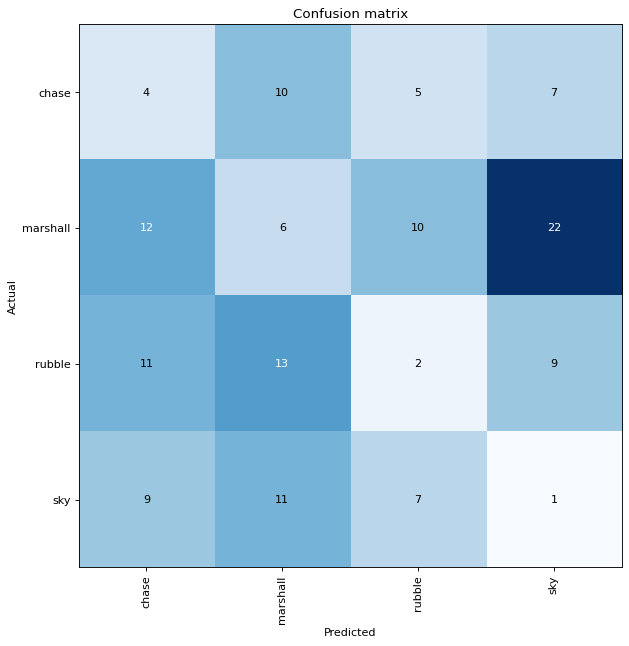

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

...and see the misclassified images in the validation set.

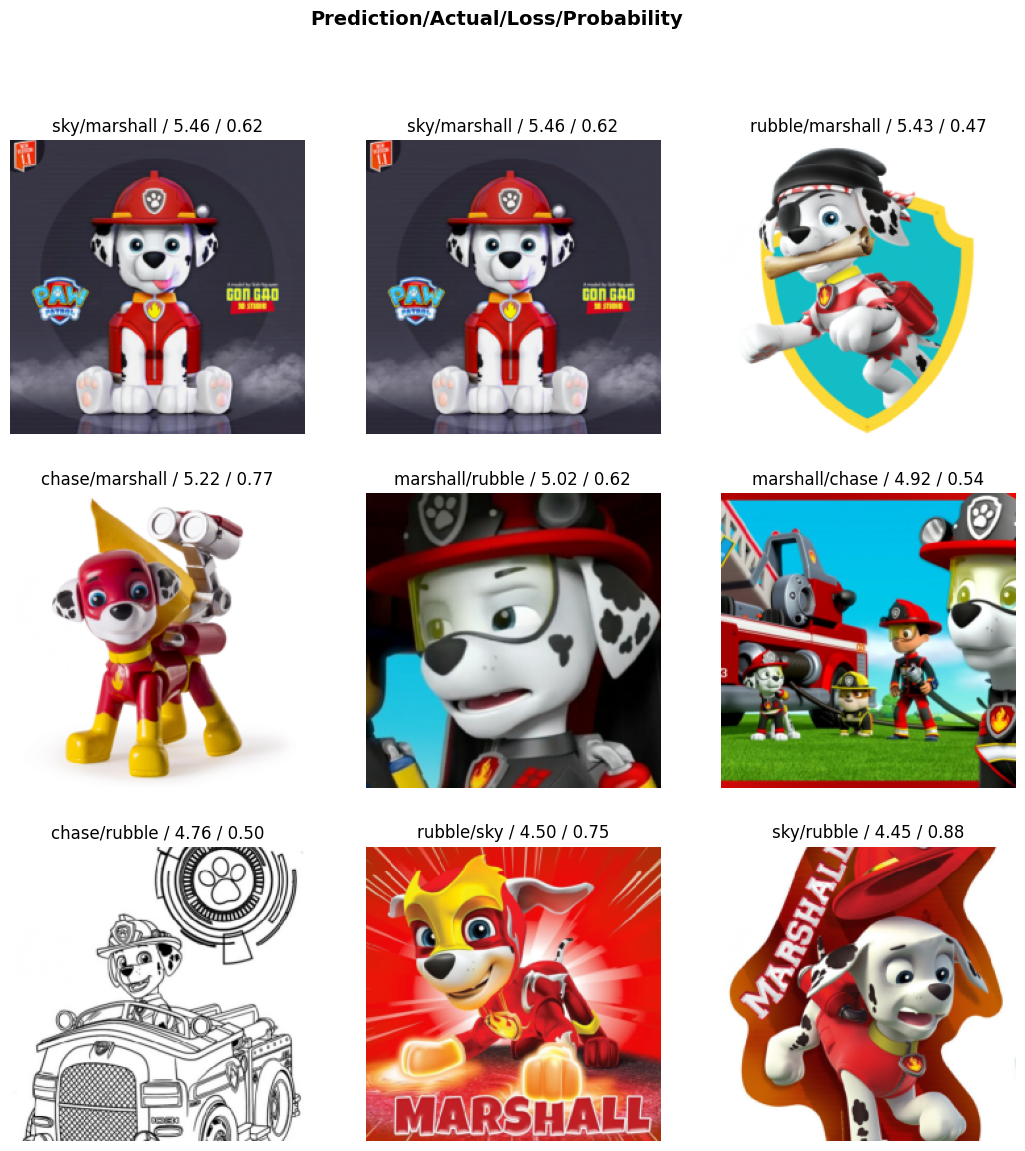

In [ ]:
interp.plot_top_losses(9, figsize=(13,13))

If you see a mess, you might want to clean your data - there is a widget for that! It will list the most suspicios images (=highest loss) per set (train/valid) and category. Mark these images for deletion...

In [ ]:
from fastai.vision.widgets import *

# TODO - repeatedly run this and following cell for each category and split (train/valid)
cleaner = ImageClassifierCleaner(learn)
cleaner

...and now actually delete them.

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.delete()))

0


After deleting the images, you need to rerun the entire notebook from the first cell to update the dataloaders, as they will point to deleted files.

## Test the model on a test set

In [ ]:
# Create a test DataLoader
test_path = Path('/teamspace/studios/this_studio/test') 
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [ ]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [ ]:
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]

In [ ]:
from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))

Test error rate:
0.7361702127659575


## Let us save the model

In [ ]:
learn.export('model.pkl')

Make sure to **download** `model.pkl` to your laptop, as you will need it later.